In [1]:
from utils_project import *
from utils_timeseries import *

import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_timeseries_embedding_plotly(embedding, c,
                                     cmap='Viridis', 
                                     mode='markers',
                                     fig=None,
                                     row=1, 
                                     col=1,
                                     **kwargs):
    n_dimensions = embedding.shape[1]
    
    if n_dimensions not in [2, 3]:
        raise ValueError("Only 2D or 3D embeddings are supported.")
        
    # Initialize the figure
    if fig is None:
        if n_dimensions == 2:
            fig = make_subplots(rows=1, cols=1)
        else:
            fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scatter3d"}]])

    if n_dimensions == 2:
        fig.add_trace(go.Scatter(x=embedding[:,0], y=embedding[:,1], 
                                    mode=mode, 
                                    marker=dict(color=c, colorscale=cmap)),
                    row=row, col=col)
    else:
        fig.add_trace(go.Scatter3d(x=embedding[:,0], y=embedding[:,1], z=embedding[:,2], 
                                    mode=mode,
                                    marker=dict(color=c, size=3, colorscale=cmap)),
                    row=row, col=col)
    return fig

def plot_timeseries_embedding(embedding, c, 
                              line=True, 
                              scatter=True, cmap='tab10', ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    if line:
        ax.plot(embedding[:,0], embedding[:,1], c='k', alpha=0.85, linewidth=0.5)
    if scatter:
        ax.scatter(embedding[:,0], embedding[:,1], s=50, c=c, cmap=cmap, edgecolor='k', linewidth=0.5)
    return ax

Detected user: /Users/matty_gee
Base directory: /Users/matty_gee/Desktop/projects/trajectory
Included n=50
Found 0 mask nifties


# Plot timeseries embeddings

In [2]:
# to color the plot
char_role_c_val  = np.repeat(decision_trials[decision_trials['char_role_num'] != 6]['char_role_num'].values, 12)
char_role_c_init = np.repeat(decision_trials[decision_trials['char_role_num'] != 6]['char_role_num'].values, 6)

# load timeseries data
ts_fnames = glob.glob(f'{base_dir}/lsa_decision_128hpf/timeseries/subs/*.mat')
ts_fnames = [f for f in ts_fnames if int(f.split('/')[-1].split('_')[0]) in incl]
print(f'Found {len(ts_fnames)} files')
subs    = [int(f.split('/')[-1].split('_')[0]) for f in ts_fnames]
missing = [s for s in incl if s not in subs]

Found 50 files


In [3]:
for ts_fname in ts_fnames:
    ts_dict  = load_ts_mat(ts_fname, preprocess=True)
    rois = list(ts_dict.keys())

    if len(ts_fname.split('/')[-1].split('_')[0]) > 2:
        task_trs = get_task_trs(tr=1.0)
        char_role_c = char_role_c_val
    else:
        task_trs = get_task_trs(tr=2.0)
        char_role_c = char_role_c_init

    # only plot the decision trials:
    mask = (task_trs['trial_type'] == 'Decision') & (task_trs['char_role_num'] != '6.0')
    tr_num_c = np.arange(np.sum(mask)) # if want to track time

    # mpfc_embedding = calc_lle_embedding(ts_dict['L_mpfc_thr25'], n_components=2)['embedding']
    # ant_embedding  = calc_lle_embedding(ts_dict['L_HPC-ant_thr25'], n_components=2)['embedding']
    # post_embedding = calc_lle_embedding(ts_dict['L_HPC-post_thr25'], n_components=2)['embedding']
    # hpc_embedding  = calc_lle_embedding(ts_dict['L_HPC_thr25'], n_components=2)['embedding']

    # plotting timeseries as individual points...
    # - need a nice way to plot the lines, colorcoded by trial...
    hpc_embedding = calc_lle_embedding(ts_dict['L_HPC_thr25'], n_components=3)['embedding']
    m1_embedding  = calc_lle_embedding(ts_dict['L_M1-p_thr25'], n_components=3)['embedding']

    # plot with plotly
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], 
                        subplot_titles=("HPC", "M1"))
    fig = plot_timeseries_embedding_plotly(hpc_embedding[mask,:], char_role_c, mode='lines', fig=fig, row=1, col=1)
    fig = plot_timeseries_embedding_plotly(m1_embedding[mask,:], char_role_c, mode='lines', fig=fig, row=1, col=2)
    fig.update_layout(height=600, width=1000, title_text="")
    fig.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 784 but corresponding boolean dimension is 786

# Tphate embeddings

In [2]:
# import tphate
# # help(tphate.TPHATE)
# def calc_tphate_embedding(X, n_components=3, n_neighbors=10, mds_solver='sgd', mds='metric', verbose=False):
#     tphate_operator = tphate.TPHATE(n_components=n_components, knn=n_neighbors,
#                                     mds_solver=mds_solver, # 'sgd' or 'smacof'
#                                     mds=mds, verbose=verbose)
#     return {'embedding': tphate_operator.fit_transform(X)}

### betas

In [1]:
# beta_fnames, _ = get_fnames('*/*beta*.pkl', glm='lsa_decision_128hpf', ftype='subs')

# beta_fname = beta_fnames[0]
# brain_dict = pd.read_pickle(beta_fname)
# betas = preprocess_betas(brain_dict['L_HPC_thr25'], zscore=False, neutrals=True)
# embedding = calc_tphate_embedding(betas)['embedding']
# plot_rdm(pairwise_distances(embedding), figsize=(5,5))
# plt.show()

# PCA explained variance
not sure if I can use this to motivate the use of this number of dimensions...?

Maybe: PCA can give idea of how many dimensions needed to explain variance but it flattens the interesting geometry w/ its linearizing 

In [22]:
beta_fnames, _ = get_fnames('*/*beta*pkl', ftype='subs')

exp_var_df = pd.DataFrame(columns=['sub_id', 'roi'] + [f'{i}' for i in range(1, 21)])
for i, fname in enumerate(beta_fnames):

    print(f'Processing {i+1}/{len(beta_fnames)}', end='\r')
    sub_id = fname.split('/')[-1].split('_')[0]
    if int(sub_id) not in incl: continue

    beta_dict = pd.read_pickle(fname)

    for roi in ['L_HPC_thr25', 'R_HPC_thr25']:
        betas     = preprocess_betas(beta_dict[roi], zscore=False, neutrals=True)
        exp_var   = calc_pca_embedding(betas, n_components=20)['explained_variance']
        exp_var_df.loc[len(exp_var_df)] = [sub_id, roi] + exp_var.tolist()

exp_var_df = exp_var_df.melt(id_vars=['sub_id', 'roi'], var_name='pc', value_name='exp_var')

Found 54 subs files
Missing subs: []


PC1 mean=0.209, t=-32.16, p=1.000
PC2 mean=0.336, t=-12.07, p=1.000
PC3 mean=0.413, t=-6.08, p=1.000
PC4 mean=0.465, t=-2.44, p=0.991
PC5 mean=0.508, t=0.55, p=0.293
PC6 mean=0.543, t=3.20, p=0.001
PC7 mean=0.574, t=5.69, p=0.000
PC8 mean=0.602, t=8.11, p=0.000
PC9 mean=0.627, t=10.47, p=0.000
PC10 mean=0.649, t=12.79, p=0.000
PC11 mean=0.669, t=15.09, p=0.000
PC12 mean=0.688, t=17.41, p=0.000
PC13 mean=0.705, t=19.77, p=0.000
PC14 mean=0.722, t=22.24, p=0.000
PC15 mean=0.737, t=24.78, p=0.000
PC16 mean=0.751, t=27.37, p=0.000
PC17 mean=0.765, t=30.05, p=0.000
PC18 mean=0.778, t=32.86, p=0.000
PC19 mean=0.789, t=35.83, p=0.000
PC20 mean=0.801, t=38.89, p=0.000


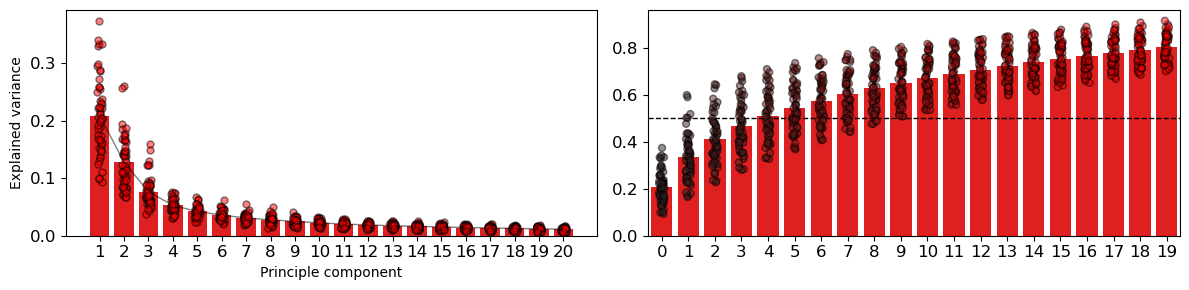

In [25]:
exp_var_df_ = exp_var_df[exp_var_df['roi']=='R_HPC_thr25']

cum_var = []
for i in range(1, 21):
    df = exp_var_df_[exp_var_df_['pc']==f'{i}'].sort_values(by='sub_id')
    exp_vars = df['exp_var'].values
    cum_var.append(exp_vars)
cum_var_ = np.cumsum(cum_var, axis=0).T

#------------------------------------------------------------------
# plot
#------------------------------------------------------------------
fig, axs = plt.subplots(1,2, figsize=(12, 3))

ax = axs[0]
sns.barplot(data=exp_var_df_, x='pc', y='exp_var', 
            color='red', ci=None, ax=ax)
sns.stripplot(data=exp_var_df_, x='pc', y='exp_var', 
              color='red', alpha=0.5, edgecolor=ec, linewidth=lw, 
              dodge=True, ax=ax)
sns.lineplot(data=exp_var_df_, x='pc', y='exp_var', color='black', 
             linewidth=lw, alpha=.5, zorder=1, ci=None, ax=ax)
ax.set_xlabel('Principle component')
ax.set_ylabel('Explained variance')
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
# ax.legend_.remove()

ax = axs[1]
sns.barplot(cum_var_, color='red', ax=ax)
sns.stripplot(cum_var_, color='red', 
              edgecolor=ec, linewidth=lw, alpha=0.5, ax=ax)
ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.tight_layout()

#------------------------------------------------------------------
#------------------------------------------------------------------

# # test each dimension for whether it is > 0.05
# print(f'n={len(np.unique(exp_var_df["sub_id"]))}')
# for i in range(len(cum_var)):
#     t, p = scipy.stats.ttest_1samp(cum_var[i], 0.02, alternative='greater')
#     print(f'PC{i+1} mean={np.mean(cum_var[i]):.2f}, t={t:.2f}, p={p:.3f}')

# print()
# test where the cumulative variance is > 0.5, with t-tests...
for i in range(len(cum_var)):
    t, p = scipy.stats.ttest_1samp(cum_var_[:, i], 0.5, alternative='greater')
    print(f'PC{i+1} mean={np.mean(cum_var_[:, i]):.3f}, t={t:.2f}, p={p:.3f}')

# MDS stress

In [27]:
stress_df = pd.DataFrame(columns=['sub_id', 'roi'] + [f'{i}' for i in range(2, 21)])
for i, fname in enumerate(beta_fnames):
    
    print(f'Processing {i+1}/{len(beta_fnames)}', end='\r')
    sub_id = fname.split('/')[-1].split('_')[0]
    if int(sub_id) not in incl: continue

    beta_dict = pd.read_pickle(fname)
    betas = preprocess_betas(beta_dict['L_HPC_thr25'], zscore=False, neutrals=True)

    # calculate stress
    stress = [
        calc_mds_embedding(betas, n_components=d, dissimilarity='correlation')['kruskal_stress']
        for d in range(2, 21)
    ]
    stress_df.loc[len(stress_df)] = [sub_id, 'L_HPC_thr25'] + stress
stress_df = stress_df.melt(id_vars=['sub_id', 'roi'], var_name='dim', value_name='stress')

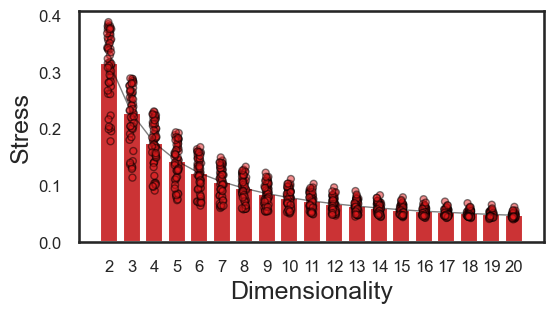

In [28]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('Set1')

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(data=stress_df, x='dim', y='stress', 
            hue='roi', ax=ax, ci=None)
sns.stripplot(data=stress_df, x='dim', y='stress', 
              hue='roi', ax=ax, 
              edgecolor='black', linewidth=1, 
              alpha=0.5, dodge=True)
sns.lineplot(data=stress_df, x='dim', y='stress', ax=ax, color='black', 
             linewidth=1, alpha=.5, zorder=1, ci=None)
ax.set_xlabel('Dimensionality')
ax.set_ylabel('Stress')
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.legend_.remove()

# General embedding helpers

In [3]:
from pyDRMetrics import pyDRMetrics as dr

def rename_dict_key(d, old_key, new_key):
    return {new_key if k == old_key else k:v for k,v in d.items()}

def calc_embedding_metrics(X, Z, Xr=None):

    drm_dict = json.loads(dr.DRMetrics(X, Z, Xr).get_json()) # put into dictionary

    #--------------------------------------------------------------------------------------------
    # r2 between embedding & original distances
    #--------------------------------------------------------------------------------------------

    # re-compute these r2 values: incorrect in DRMetrics package b/c incl. diagonal
    Xd = symm_mat_to_ut_vec(pairwise_distances(X))
    Zd = symm_mat_to_ut_vec(pairwise_distances(Z))
    drm_dict['Vr'] = scipy.stats.pearsonr(Xd, Zd)[0] ** 2
    drm_dict['Vrs'] = scipy.stats.spearmanr(Xd, Zd)[0] ** 2

    # also calculate r2 for correlation w/ correlation distances
    Xd = symm_mat_to_ut_vec(1 - np.corrcoef(X))
    drm_dict['r2_corrd_pearson'] = scipy.stats.pearsonr(Xd, Zd)[0] ** 2
    drm_dict['r2_corrd_spearman'] = scipy.stats.spearmanr(Xd, Zd)[0] ** 2

    #--------------------------------------------------------------------------------------------
    # rename keys
    #--------------------------------------------------------------------------------------------

    renames = {'AUC':'AUC_coKNN', 'AUC_T': 'AUC_Trustworthiness', 'AUC_C': 'AUC_Continuity',
               'kmax': 'kmax_coKNN', 'Qlocal': 'Qlocal_coKNN', 'Qglobal': 'Qglobal_coKNN',
               'mse':'recon_MSE', 'rmse':'recon_rMSE', 'ms': 'orig_ms', # only if have inverse transform
               'Vr':'r2_eucd_pearson', 'Vrs':'r2_eucd_spearman'} 
    for old, new in renames.items(): drm_dict = rename_dict_key(drm_dict, old, new) 
    
    return drm_dict
              
def calc_embedding_rsa(emb, rdv):
    return kendalltau(symm_mat_to_ut_vec(pairwise_distances(emb)), rdv)[0]

# Reconstruction score
need an inverse transform to see how much of original distances are maintained?


### Compare R2 with orig. euclidean & correlation distances

- PCA should relate closely onto Euclidean distances
- MDS should relate closely to correlation distances
- IsoMap can be either or neither? Trying to track the geodesic distances...


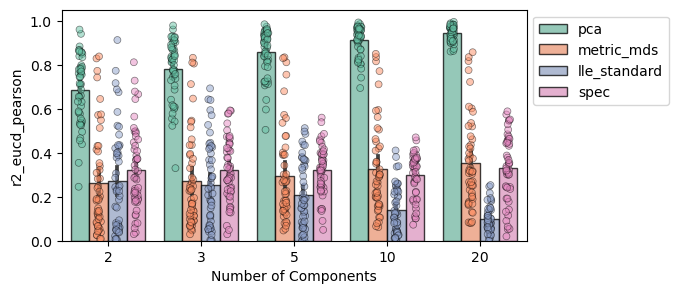

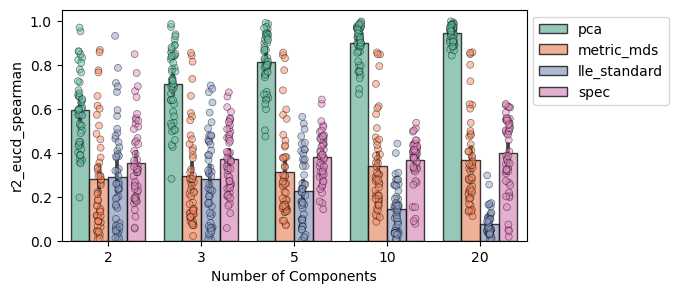

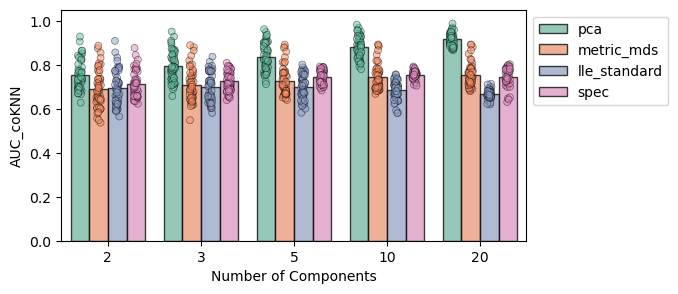

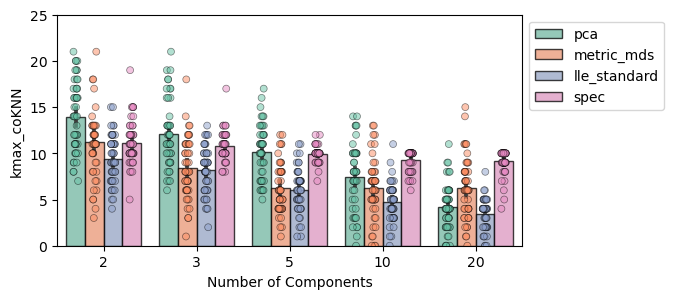

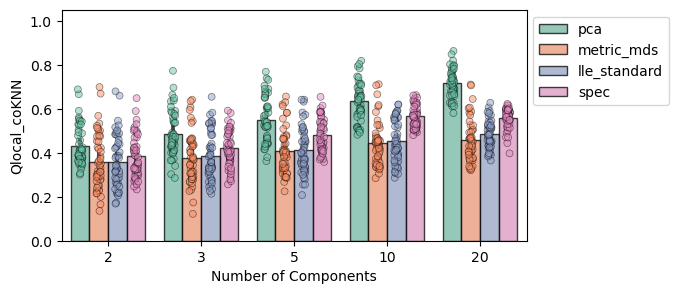

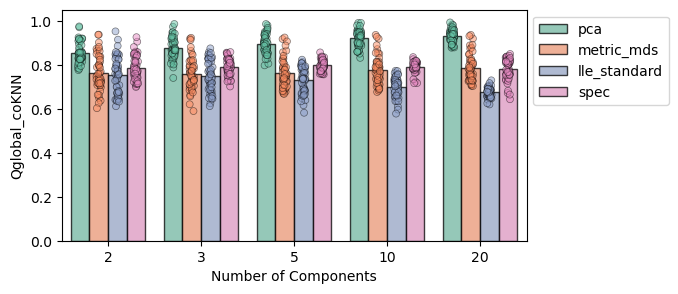

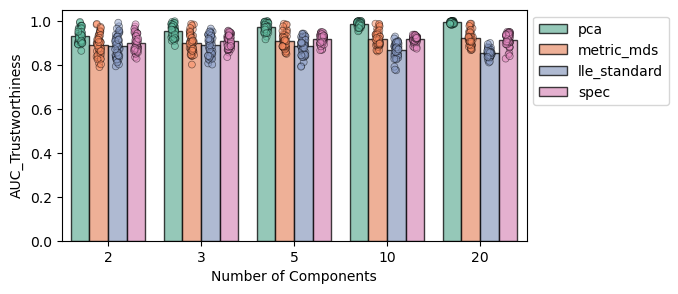

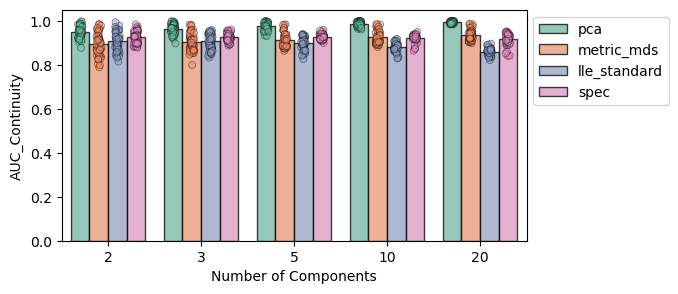

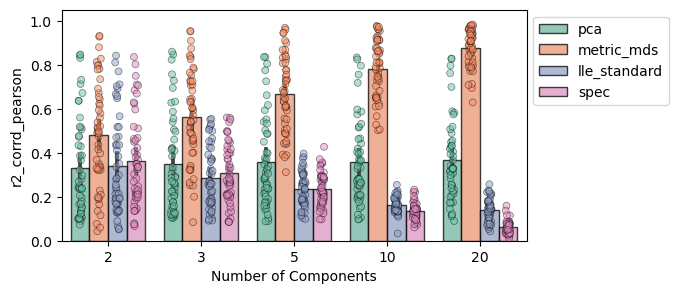

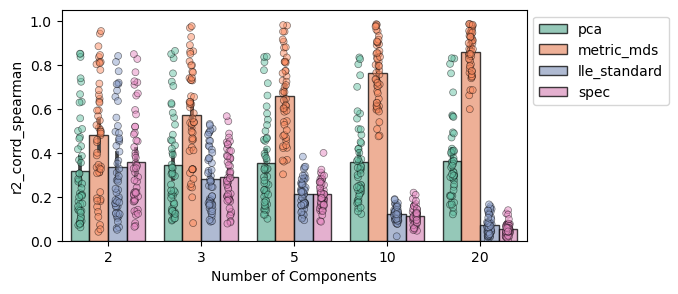

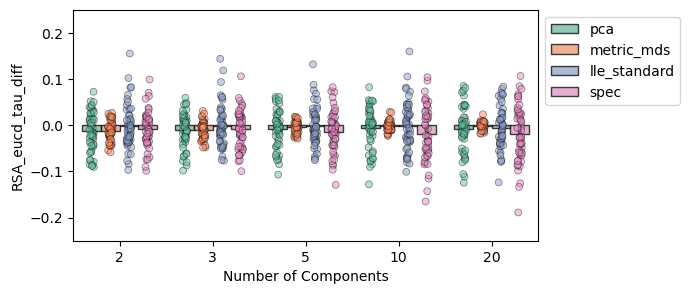

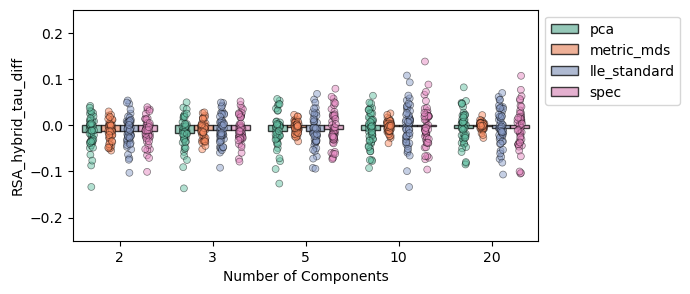

In [55]:
# load 
drm_df = pd.read_excel(f'{emb_dir}/Embeddings_summary.xlsx')
drm_df_ = drm_df[(drm_df['method'] != 'rsa') & (drm_df['method'] != 'nonmetric_mds')]

drm_df_ = drm_df_[drm_df_['roi'] == 'R_HPC_10']
metrics = list(drm_df_.columns[5:])
n_methods = len(np.unique(drm_df_['method']))

#--------------------------------------------------------------------------------
# plot metrics
#--------------------------------------------------------------------------------

for metric in metrics: 

    if 'kmax' in metric:    ylim = (0, 25)
    elif '_tau_' in metric: ylim = (-.25, .25)
    else:                   ylim = (0, 1.05)
    
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    sns.barplot(data=drm_df_, x='n_comps', y=metric, hue='method', ax=ax, 
                alpha=0.75, edgecolor='black', palette='Set2')
    sns.stripplot(data=drm_df_, x='n_comps', y=metric, hue='method', ax=ax, 
                dodge=True, alpha=0.5, edgecolor='black', linewidth=0.5, palette='Set2')
    ax.set_ylim(ylim)
    ax.set_xlabel('Number of Components')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[n_methods:], labels=labels[n_methods:], loc='upper left', bbox_to_anchor=(1,1))
    plt.show()
